In [1]:
from scipy import stats
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
import seaborn as sns
import numpy as np
import pandas as pd
from causalgraphicalmodels import CausalGraphicalModel

## The Fork
In a fork a variable confounds others. 
In the example below, **C** cofounds **A** and **B**. And that means that if we want to learn **B** then **A** tells nothing about it when we condition on **C**.
<br>
<br>
**A** and **B** are independent, conditional on **C**.<br>
Conditioning on **C** blocks the path between **A** and **B**.

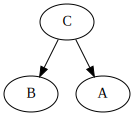

In [2]:
# the fork
assoc = CausalGraphicalModel(
    nodes=["A", "B", "C"], edges=[("C", "A"), ("C", "B")]
)

assoc.draw()

Lets run 2 simulations to see how the fork works. 
<br>
First we need to simulate some data.

In [3]:
SAMP_SIZE = 100

np.random.seed(89)
C = stats.norm.rvs(size=SAMP_SIZE) 
B = stats.norm.rvs(C)
A = stats.norm.rvs(C)

df = pd.DataFrame.from_dict({"A": A, "B": B, "C": C})

Regressing **B** on **A** we have:

In [4]:
with pm.Model() as m_fork:
    a = pm.Normal('a', mu=0, sigma=1)
    bA = pm.Normal('bA', mu=0, sigma=1)
    
    mu = a + bA*df.A
    sigma = pm.Exponential('sigma', 1)
    
    B = pm.Normal('B', mu=mu, sigma=sigma, observed=df.B)
    
    m_fork_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:00<00:00, 5851.58draws/s]


In [5]:
az.summary(m_fork_trace, round_to=2, kind="stats")

/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%
a,-0.14,0.13,-0.41,0.10
bA,0.45,0.09,0.28,0.62
sigma,1.28,0.09,1.12,1.45


We can see by the coeficient **bA** that **A** has some positive correlation with **B**.  

Regressing **B** on **A** and **C**:

In [6]:
with pm.Model() as m_fork:
    a = pm.Normal('a', mu=0, sigma=1)
    bA = pm.Normal('bA', mu=0, sigma=1)
    bC = pm.Normal('bC', mu=0, sigma=1)
    
    mu = a + bA*df.A + bC*df.C
    sigma = pm.Exponential('sigma', 1)
    
    B = pm.Normal('B', mu=mu, sigma=sigma, observed=df.B)
    
    m_fork_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bC, bA, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:00<00:00, 4482.43draws/s]


In [7]:
az.summary(m_fork_trace, round_to=2, kind="stats")

/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%
a,-0.03,0.11,-0.23,0.17
bA,-0.11,0.11,-0.32,0.09
bC,1.14,0.16,0.83,1.45
sigma,1.04,0.08,0.90,1.19


However, when we add **C** in the model, which is the confounding, **A** doesn't tell anything else about **B**. That can be seen by the **A**'s coeficient being around zero.

## The Pipe
As for the Pipe, when we condition on **C** we block the path between **A** and **B**.

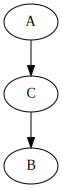

In [8]:
# the pipe
assoc = CausalGraphicalModel(
    nodes=["A", "B", "C"], edges=[("A", "C"), ("C", "B")]
)

assoc.draw()

Bellow we simulate the data.

In [9]:
SAMP_SIZE = 100

np.random.seed(89)
A = stats.norm.rvs(size=SAMP_SIZE) 
C = stats.norm.rvs(A)
B = stats.norm.rvs(C)

df = pd.DataFrame.from_dict({"A": A, "B": B, "C": C})

Regressing **B** on **A** we have:

In [10]:
with pm.Model() as m_pipe:
    a = pm.Normal('a', mu=0, sigma=1)
    bA = pm.Normal('bA', mu=0, sigma=1)
    
    mu = a + bA*df.A
    sigma = pm.Exponential('sigma', 1)
    
    B = pm.Normal('B', mu=mu, sigma=sigma, observed=df.B)
    
    m_pipe_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:00<00:00, 6110.96draws/s]


In [11]:
az.summary(m_pipe_trace, round_to=2, kind="stats")

/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%
a,0.08,0.13,-0.17,0.31
bA,1.15,0.14,0.90,1.43
sigma,1.33,0.10,1.16,1.51


The coeficient **bA** shows a high positive correlation between **A** and **B**.  

Regressing **B** on **A** and **C**:

In [12]:
with pm.Model() as m_pipe:
    a = pm.Normal('a', mu=0, sigma=1)
    bA = pm.Normal('bA', mu=0, sigma=1)
    bC = pm.Normal('bC', mu=0, sigma=1)
    
    mu = a + bA*df.A + bC*df.C
    sigma = pm.Exponential('sigma', 1)
    
    B = pm.Normal('B', mu=mu, sigma=sigma, observed=df.B)
    
    m_pipe_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bC, bA, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:00<00:00, 4457.34draws/s]


In [13]:
az.summary(m_pipe_trace, round_to=2, kind="stats")

/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%
a,0.12,0.10,-0.08,0.29
bA,0.27,0.14,0.01,0.53
bC,0.88,0.09,0.70,1.05
sigma,0.96,0.07,0.83,1.09


However, when we condition on **C** the information of **A** is blocked and we can see a coeficient closer to zero (the more data we have the closer to zero it will be).

## The Collider
The collider is an interesting case, on the diagram bellow, contrary to the 2 previous cases, the information does not flow between **A** and **B** if we don't condition on **C**.

It's important to notice that there's no casual influence between **A** and **B**.

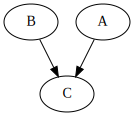

In [14]:
# the collider
assoc = CausalGraphicalModel(
    nodes=["A", "B", "C"], edges=[("A", "C"), ("B", "C")]
)

assoc.draw()

In [15]:
SAMP_SIZE = 100

np.random.seed(89)
A = stats.norm.rvs(size=SAMP_SIZE) 
B = stats.norm.rvs(size=SAMP_SIZE)
C = stats.norm.rvs(A+B)

df = pd.DataFrame.from_dict({"A": A, "B": B, "C": C})

Regressing **B** on **A** we have:

In [16]:
with pm.Model() as m_coll:
    a = pm.Normal('a', mu=0, sigma=1)
    bA = pm.Normal('bA', mu=0, sigma=1)
    
    mu = a + bA*df.A
    sigma = pm.Exponential('sigma', 1)
    
    B = pm.Normal('B', mu=mu, sigma=sigma, observed=df.B)
    
    m_coll_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:00<00:00, 5901.71draws/s]


In [17]:
az.summary(m_coll_trace, round_to=2, kind="stats")

/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%
a,-0.05,0.11,-0.26,0.15
bA,0.02,0.11,-0.18,0.24
sigma,1.04,0.08,0.90,1.18


The coeficient **bA** shows no correlation between **A** and **B**.  

Regressing **B** on **A** and **C**:

In [18]:
with pm.Model() as m_coll:
    a = pm.Normal('a', mu=0, sigma=1)
    bA = pm.Normal('bA', mu=0, sigma=1)
    bC = pm.Normal('bC', mu=0, sigma=1)
    
    mu = a + bA*df.A + bC*df.C
    sigma = pm.Exponential('sigma', 1)
    
    B = pm.Normal('B', mu=mu, sigma=sigma, observed=df.B)
    
    m_coll_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bC, bA, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:00<00:00, 4328.44draws/s]


In [19]:
az.summary(m_coll_trace, round_to=2, kind="stats")

/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%
a,-0.08,0.08,-0.22,0.06
bA,-0.60,0.11,-0.79,-0.41
bC,0.54,0.06,0.43,0.64
sigma,0.75,0.05,0.66,0.86


However, when we condition on **C** the information of **A** flows to **B**. We can notice this by the considerable negative coeficient **bA**.

## The Descendant
Conditioning on a descendant partially conditions on its parent.
For the DAG bellow, conditioning on **D** partially conditions on **C** and we have as a result some information flowing from **A** to **B** even by not conditioning on **CC**.

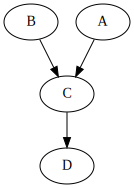

In [20]:
# the descendant
assoc = CausalGraphicalModel(
    nodes=["A", "B", "C", "D"], edges=[("A", "C"), ("B", "C"), ("C", "D")]
)

assoc.draw()

In [21]:
SAMP_SIZE = 100

np.random.seed(89)
A = stats.norm.rvs(size=SAMP_SIZE) 
B = stats.norm.rvs(size=SAMP_SIZE)
C = stats.norm.rvs(A+B)
D = stats.norm.rvs(C)

df = pd.DataFrame.from_dict({"A": A, "B": B, "C": C, "D": D})

Regressing **B** on **A** we have:

In [22]:
with pm.Model() as m_desc:
    a = pm.Normal('a', mu=0, sigma=1)
    bA = pm.Normal('bA', mu=0, sigma=1)
    
    mu = a + bA*df.A
    sigma = pm.Exponential('sigma', 1)
    
    B = pm.Normal('B', mu=mu, sigma=sigma, observed=df.B)
    
    m_desc_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:00<00:00, 6126.83draws/s]


In [23]:
az.summary(m_desc_trace, round_to=2, kind="stats")

/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%
a,-0.04,0.10,-0.22,0.15
bA,0.03,0.11,-0.19,0.23
sigma,1.04,0.08,0.90,1.19


The coeficient **bA** shows no correlation between **A** and **B**.  

Regressing **B** on **A** and **D**:

In [24]:
with pm.Model() as m_desc:
    a = pm.Normal('a', mu=0, sigma=1)
    bA = pm.Normal('bA', mu=0, sigma=1)
    bD = pm.Normal('bD', mu=0, sigma=1)
    
    mu = a + bA*df.A + bD*df.D
    sigma = pm.Exponential('sigma', 1)
    
    B = pm.Normal('B', mu=mu, sigma=sigma, observed=df.B)
    
    m_desc_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bD, bA, a]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:00<00:00, 4657.37draws/s]


In [25]:
az.summary(m_desc_trace, round_to=2, kind="stats")

/home/elisio/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%
a,-0.08,0.09,-0.26,0.08
bA,-0.36,0.12,-0.59,-0.15
bD,0.31,0.06,0.21,0.41
sigma,0.91,0.07,0.78,1.03


By conditioning on **D** some information then flows from **A** to **B**.